# Startup Investment Trend Analyzer
End-to-end analysis and prediction using startup funding data.

## Dataset
- Use [Startup Funding Dataset from Kaggle](https://www.kaggle.com/datasets/ruchi798/startup-investments)



In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("indian_startup_funding.csv", encoding='utf-8')


# Quick look
# print(df.head())
# print(df.info())

# Select relevant columns & rename for clarity
df = df[['Date', 'Startup Name', 'Industry', 'Location', 'Investment Type', 'Amount in USD']]
df=df.rename(columns={'Date':'date','Startup Name': 'startup_name', 'Industry':'industry','Location': 'location','Investment Type': 'investment_type', 'Amount in USD':'funding_amount'})

# Clean funding_amount, convert to numeric (remove commas and missing data)
df['funding_amount'] = df['funding_amount'].astype(str).str.replace(',', '').str.strip()
df['funding_amount'] = pd.to_numeric(df['funding_amount'], errors='coerce')

 # Parse date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

 # Drop rows with missing key info
df.dropna(subset=['date', 'funding_amount', 'industry', 'location'], inplace=True)

# Create year column
df['year'] = df['date'].dt.year

df.head()

,date,startup_name,industry,location,investment_type,funding_amount,year
0,2021-04-14,Swiggy,Online Food Delivery,Bengaluru,Series J,343000000.0,2021
1,2021-04-14,Beldara,E-commerce,Mumbai,Venture,7400000.0,2021
2,2021-04-07,Groww,FinTech,Bengaluru,Series D,83000000.0,2021
3,2021-04-05,Meesho,E-commerce,Bengaluru,Series E,300000000.0,2021
4,2021-04-01,BYJU’S,Edu-tech,Bengaluru,Series F,460000000.0,2021


## Store Raw Data in MongoDB

In [2]:


import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client['startup_analysis']
collection = db['funding_data']

collection.delete_many({})
collection.insert_many(df.to_dict('records'))
print("Inserted data into MongoDB")

Inserted data into MongoDB


## Query MongoDB for Funding Trends

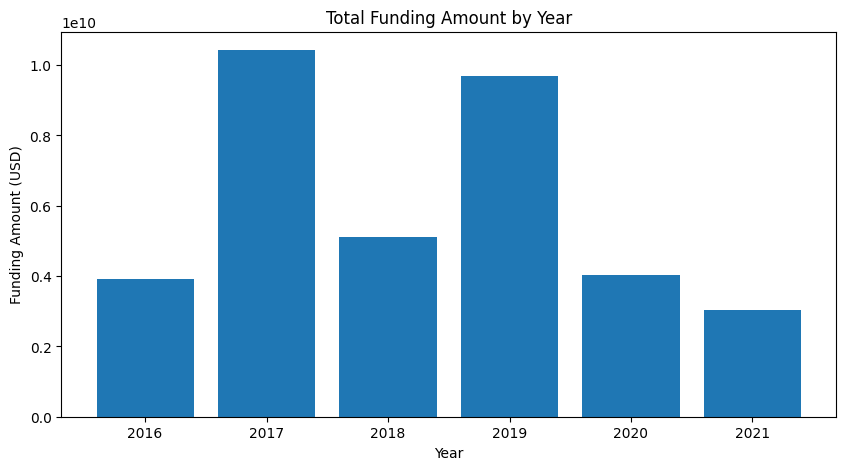

In [3]:

pipeline = [
    {
        "$group": {
            "_id": "$year",
            "total_funding": {"$sum": "$funding_amount"}
        }
    },
    {"$sort": {"_id": 1}}
]

results = list(collection.aggregate(pipeline))

years = [res['_id'] for res in results]
totals = [res['total_funding'] for res in results]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(years, totals)
plt.title("Total Funding Amount by Year")
plt.xlabel("Year")
plt.ylabel("Funding Amount (USD)")
plt.show()

## SQL Queries with SQLite

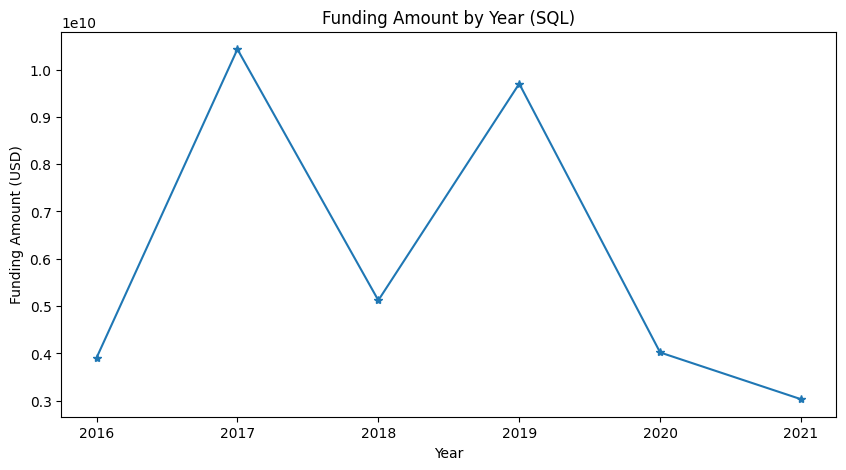

In [4]:

import sqlite3

conn = sqlite3.connect('startup_funding.db')
df.to_sql('funding', conn, if_exists='replace', index=False)

query = """
SELECT year, SUM(funding_amount) AS total_funding
FROM funding
GROUP BY year
ORDER BY year;
"""

df_sql = pd.read_sql(query, conn)

plt.figure(figsize=(10,5))
plt.plot(df_sql['year'], df_sql['total_funding'], marker='*')
plt.title('Funding Amount by Year (SQL)')
plt.xlabel('Year')
plt.ylabel('Funding Amount (USD)')
plt.show()

## EDA - Top Funded Industries & Locations

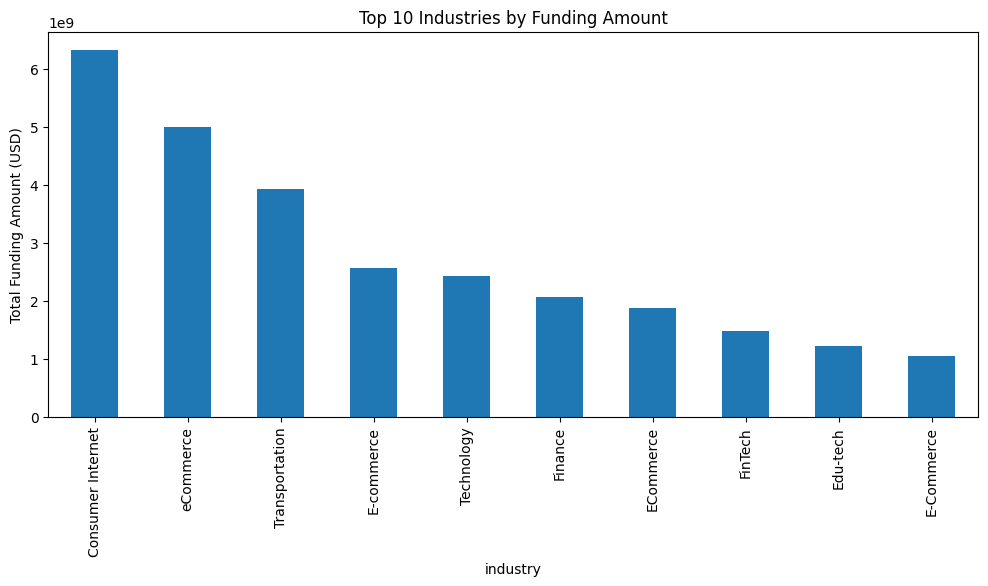

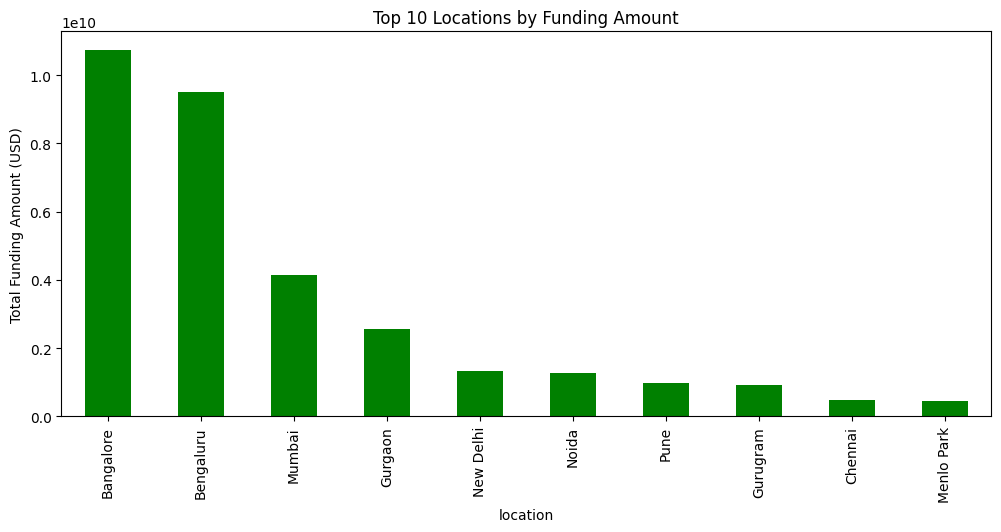

In [5]:
# EDA (Exploratory Data Analysis)

top_industries = df.groupby('industry')['funding_amount'].sum().sort_values(ascending=False).head(10)
top_locations = df.groupby('location')['funding_amount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,5))
top_industries.plot(kind='bar')
plt.title('Top 10 Industries by Funding Amount')
plt.ylabel('Total Funding Amount (USD)')
plt.show()

plt.figure(figsize=(12,5))
top_locations.plot(kind='bar', color='green')
plt.title('Top 10 Locations by Funding Amount')
plt.ylabel('Total Funding Amount (USD)')
plt.show()

## Predict Funding Amount (Regression)

In [6]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

features = df[['industry', 'location', 'investment_type']].copy()
target = df['funding_amount']

#features['investment_type'].fillna('Unknown', inplace=True)
features['investment_type'] = features['investment_type'].fillna('Unknown')


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

categorical_features = ['industry', 'location', 'investment_type']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 24240409.045277275


## Hypertuning

In [7]:

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
from joblib import dump, load


import random
np.random.seed(42)

# Synthetic funding round encoded as string (Seed, Series A, Series B, Series C)
df['funding_round'] = np.random.choice(['Seed', 'Series A', 'Series B', 'Series C'], size=len(df))
df['founding_year'] = df['year'] - np.random.randint(0, 10, size=len(df))  # startup age 0 to 9 years
df['startup_age'] = df['year'] - df['founding_year']

# Features and target
features = df[['industry', 'location', 'investment_type', 'funding_round', 'startup_age']].copy()
target = df['funding_amount']


features['investment_type']=features['investment_type'].fillna('Unknown')
features['funding_round']=features['funding_round'].fillna('Unknown')
features['startup_age']=features['startup_age'].fillna(features['startup_age'].median())



X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

categorical_features = ['industry', 'location', 'investment_type', 'funding_round']
numeric_features = ['startup_age']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numeric_features)
])

model = RandomForestRegressor(random_state=42)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
#
# Save the full pipeline
dump(best_model, 'startup_pred.joblib')
print("Model saved to 'startup_pred.joblib'")

y_pred = best_model.predict(X_test)
print("Mean Absolute Error after tuning:", mean_absolute_error(y_test, y_pred))

Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Model saved to 'startup_pred.joblib'
Mean Absolute Error after tuning: 21247431.8858928
